# A first attempt at training on the maria data

Here we are trying to train a transformer on the TODs directly, mapping to the CMB tod component.

## Step 1: Generate data with maria

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt

import maria

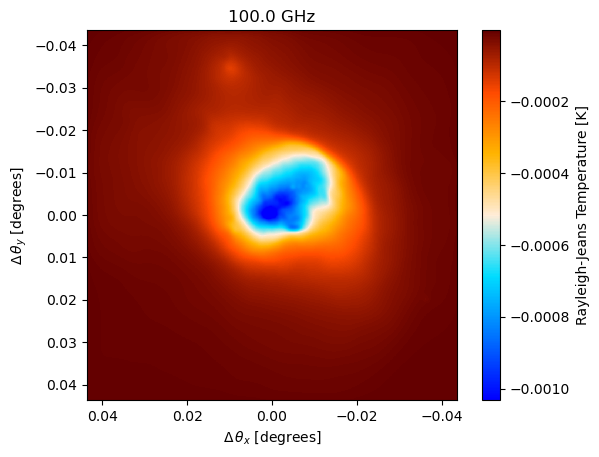

In [2]:
map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

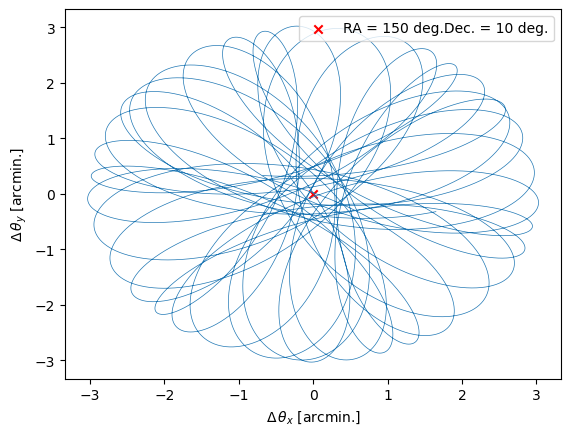

In [3]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

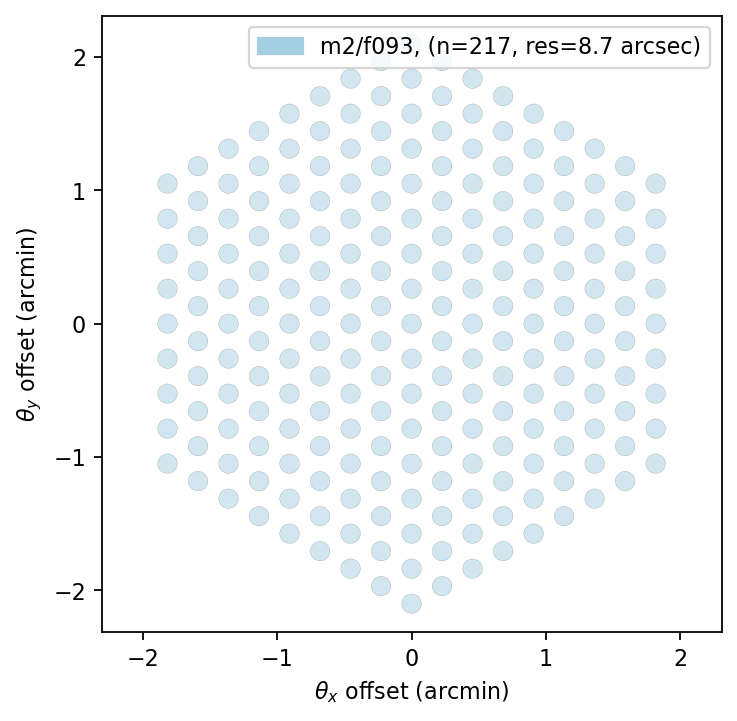

In [4]:
instrument = maria.get_instrument('MUSTANG-2')
instrument.plot()

In [5]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       atmosphere="2d",
                       cmb="generate",
                      )

tod = sim.run()

2024-07-11 15:19:27.885 INFO: Constructed instrument.
2024-07-11 15:19:27.886 INFO: Constructed plan.
2024-07-11 15:19:27.887 INFO: Constructed site.
2024-07-11 15:19:28.444 INFO: Constructed boresight.
2024-07-11 15:19:28.727 INFO: Constructed offsets.


Initialized base in 842 ms.


Generating CMB:   0%|          | 0/1 [00:00<?, ?it/s]2024-07-11 15:19:30.645 INFO: Sigma is 0.000000 arcmin (0.000000 rad) 
2024-07-11 15:19:30.646 INFO: -> fwhm is 0.000000 arcmin
Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.09it/s]
Generating atmosphere: 4it [00:00,  4.02it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.17s/it]


Data and components are stored in tod.components and tod.data:

In [6]:
tod.components

{'atmosphere': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'cmb': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'map': dask.array<array, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>,
 'noise': dask.array<setitem, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>}

In [7]:
tod.data

dask.array<add, shape=(217, 30000), dtype=float32, chunksize=(217, 30000), chunktype=numpy.ndarray>

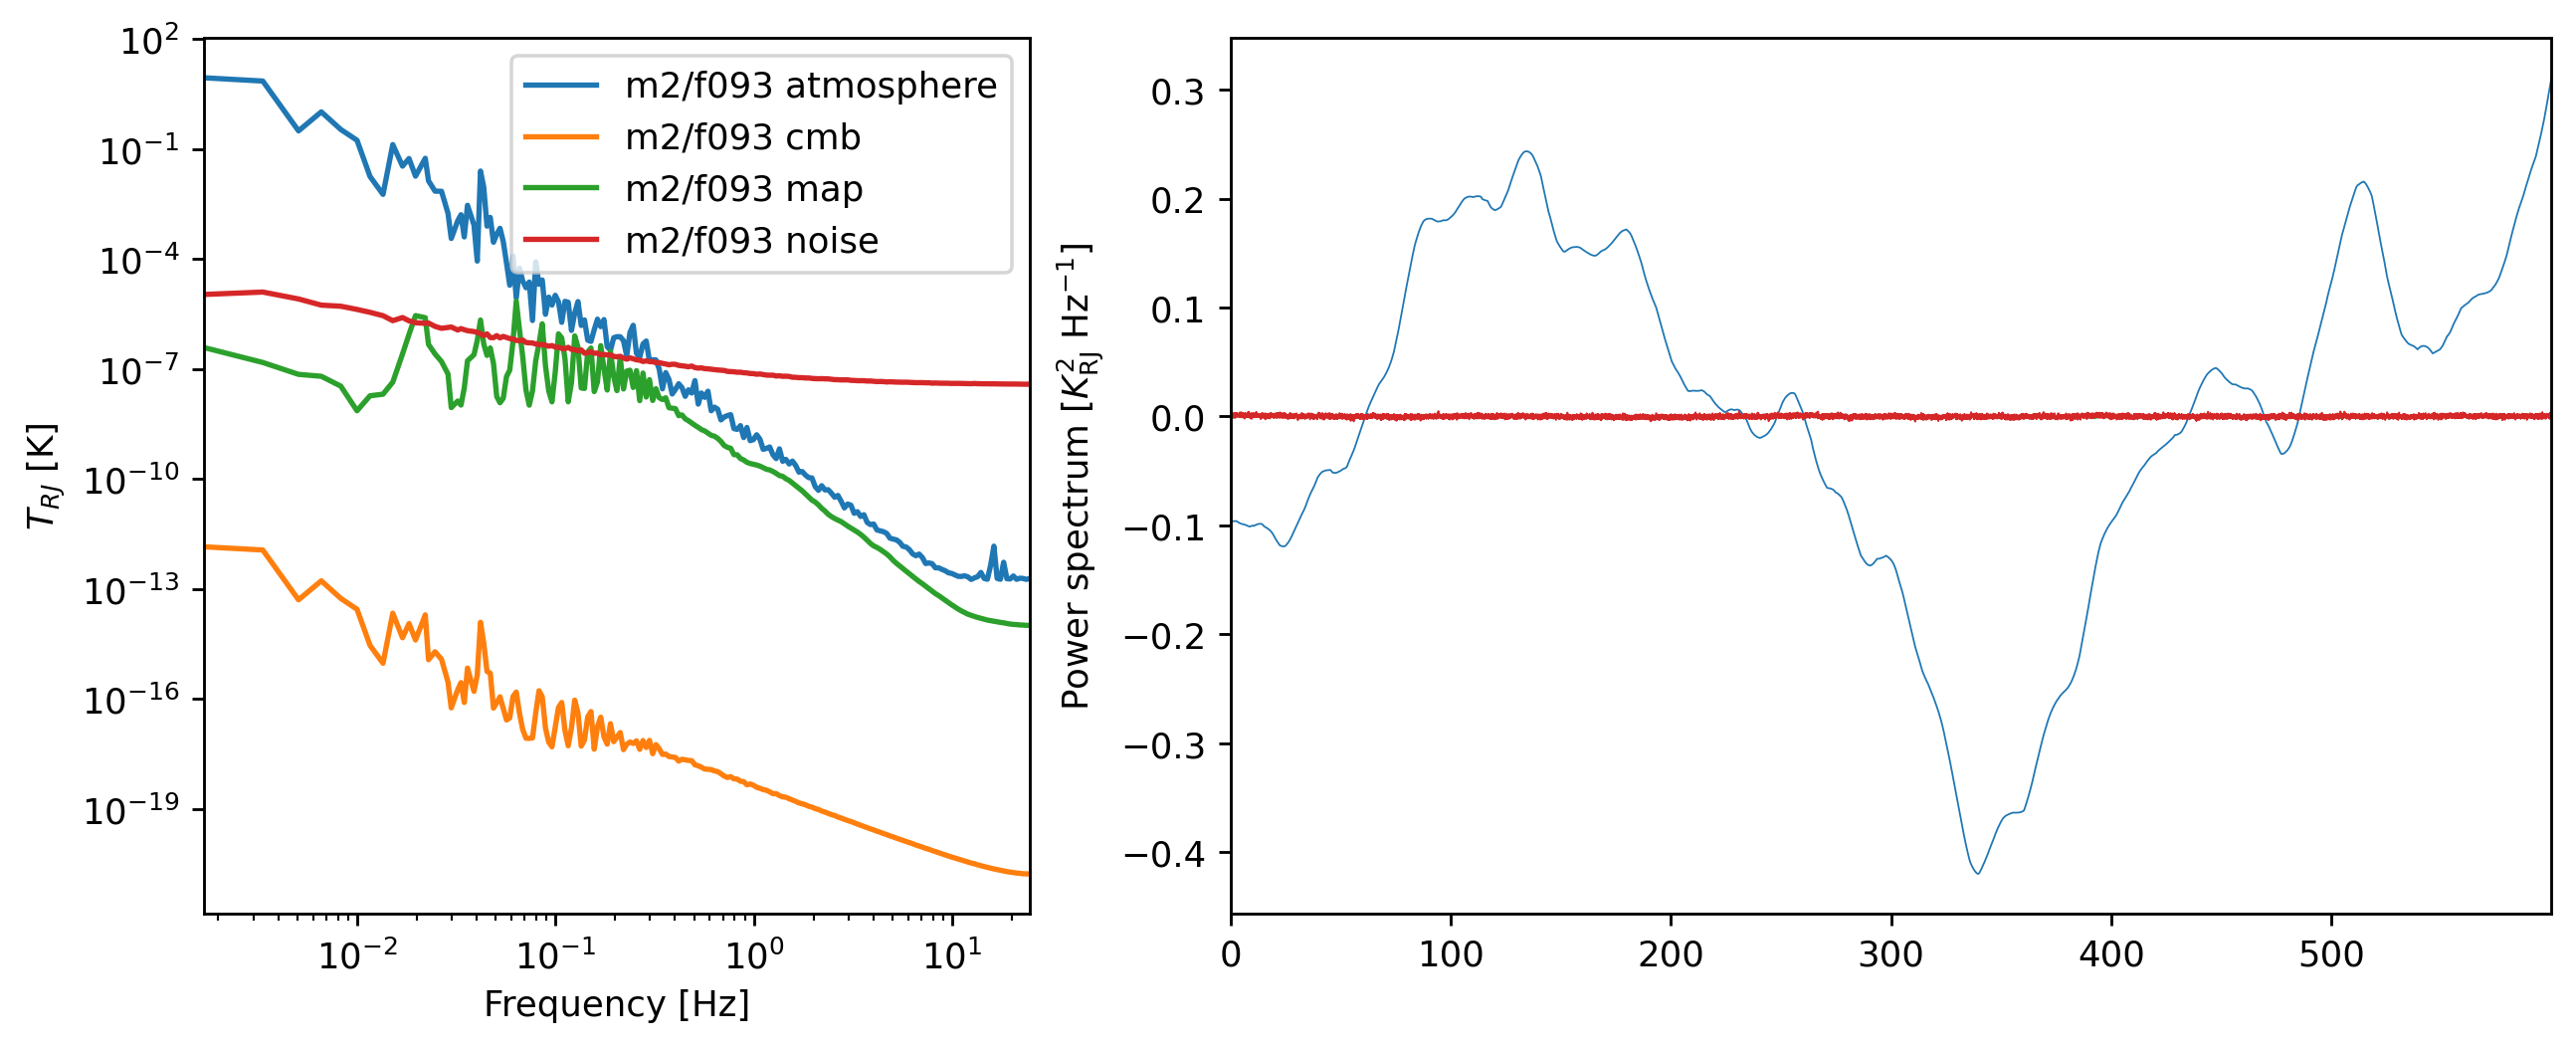

In [8]:
tod.plot(calibrate=True, detrend=True)

## Baseline reco to compare to:

baseline denoised TOD does not exist anymore?

Running mapper (m2/f093): 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]


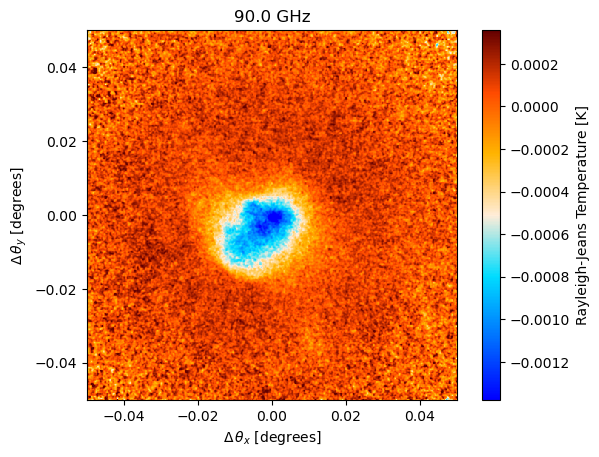

In [9]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10), 
                   frame="ra_dec", 
                   width=0.1, 
                   height=0.1,
                   resolution=2e-4,
                   tod_postprocessing={
                        "remove_modes": {"n": 1},
                        # "highpass": {"f": 0.01},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)
output_map = mapper.run()

output_map.plot()

In [10]:
# TODO: Make plot of baseline PS. Broken atm, since `mapper.DATA` does not exist anymore.
# See working: https://github.com/thomaswmorris/maria/blob/f0ea09ee2e97d70bfb07bbdfb520aa4ebd79ac55/docs/source/tutorials/MUSTANG-2_cluster.ipynb
# vs new: https://thomaswmorris.com/maria/tutorials/MUSTANG-2_cluster.html

# dt = (tod.time[1] - tod.time[0]).compute()
# data = mapper.DATA

# # visualize powerspectrum
# # -----------------------
# f, ps = sp.signal.periodogram(data, fs=1/dt, window="tukey")

# fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
# fig.suptitle('Raw time streams')

# for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 1)

# axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Combined", alpha = 0.7, c = 'C0', lw = 1.5, ls = '-')

# axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"), 
# axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
# axes[0].loglog()
# axes[0].legend(loc = 1, frameon=False)
# axes[0].axis(xmin=1e-2, xmax = 2e2, ymin = 1e-10, ymax = 1e2)

# axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
# axes[1].plot((tod.time - tod.time[0])/60, data[0], label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '-')
# plt.show()

## Step 2: Set up transformer

Question: How do we tokenise? Since we do already have numbers, maybe we don't need to?

In [11]:
def tokenize():
    return

tod.data.compute()

array([[12.166383 , 12.166321 , 12.166043 , ..., 12.189572 , 12.189274 ,
        12.189679 ],
       [12.166395 , 12.166237 , 12.16636  , ..., 12.189671 , 12.189313 ,
        12.189534 ],
       [12.165978 , 12.165822 , 12.165849 , ..., 12.189051 , 12.189066 ,
        12.189397 ],
       ...,
       [12.169519 , 12.169243 , 12.169838 , ..., 12.19266  , 12.193357 ,
        12.1925125],
       [12.164093 , 12.16408  , 12.163818 , ..., 12.1870165, 12.187007 ,
        12.186995 ],
       [12.167931 , 12.167889 , 12.168077 , ..., 12.1909075, 12.191588 ,
        12.190782 ]], dtype=float32)

In [12]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = torch.device('cuda')
torch.cuda.set_device(2) # which GPU to use
torch.set_num_threads(4) # how many threads to fill workers with
print("Using device:", DEVICE)

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                # src_padding_mask: Tensor,
                # tgt_padding_mask: Tensor,
                # memory_key_padding_mask: Tensor
                ):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        # outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
        #                         src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                None, None, None)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

Using device: cuda


set up subsequent word mask & mask to hide source and target padding tokens (do we want this here?)

In [13]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    # src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    # tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    # return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask
    
    return src_mask, tgt_mask

Question: What is vocab size here?

In [35]:
torch.manual_seed(0)

# SRC_VOCAB_SIZE = len(vocab_transform[SRC_DATA])
SRC_VOCAB_SIZE = int(len(torch.tensor(tod.data.compute()).reshape(-1, 1))/1e4)
TGT_VOCAB_SIZE = int(len(torch.tensor(tod.data.compute()).reshape(-1, 1))/1e4)
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
# BATCH_SIZE = 128
BATCH_SIZE = 2
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

# loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
loss_fn = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

/scratch/users/jwuerzin/miniconda3/envs/maria/lib/python3.11/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [44]:
tod = sim.run()

Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
Generating atmosphere: 4it [00:00,  5.38it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.11s/it]


In [54]:
# tod = sim.run() # generate data on the fly!

tod.data[0].compute().shape
# train_data = (torch.tensor(tod.data.compute()), torch.tensor(tod.components['cmb'].compute()))
# train_data = [ [1,2,3], [4,5,6]]
# train_data = 
# train_dataloader = DataLoader(train_data, batch_size=100)

# for x in train_dataloader:
#     print(x)

(30000,)

In [63]:
from torch.utils.data import DataLoader

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    # train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    tod = sim.run() # generate data on the fly!
    # train_data = [torch.tensor(tod.data.compute().reshape(1, -1)), torch.tensor(tod.components['cmb'].compute().reshape(1, -1))]
    # train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
    
    # for src, tgt in train_dataloader:
    # for src in train_dataloader:
        # print(src, src.shape())

    src = torch.tensor(tod.data[0].compute())
    tgt = torch.tensor(tod.components['cmb'][0].compute())

    src = src.to(DEVICE)
    tgt = tgt.to(DEVICE)

    print(src)

    # tgt_input = tgt[:-1, :]
    tgt_input = tgt

    # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
    src_mask, tgt_mask, = create_mask(src, tgt_input)

    # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
    logits = model(src, tgt_input, src_mask, tgt_mask)

    optimizer.zero_grad()

    # tgt_out = tgt[1:, :]
    tgt_out = tgt
    loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
    loss.backward()

    optimizer.step()
    losses += loss.item()

    # return losses / len(list(train_dataloader))
    return losses


def evaluate(model):
    model.eval()
    losses = 0

    # val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    # tod_val = sim.run() # enable later!
    rod_val = tod
    val_data = [torch.tensor(tod_val.data.compute().reshape(1, -1)), torch.tensor(tod_val.components['cmb'].compute().reshape(1, -1))]
    val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        # tgt_input = tgt[:-1, :]
        tgt_input = tgt

        # src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        src_mask, tgt_mask = create_mask(src, tgt_input)

        # logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        logits = model(src, tgt_input, src_mask, tgt_mask)

        # tgt_out = tgt[1:, :]
        tgt_out = tgt
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(list(val_dataloader))

In [64]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
# NUM_EPOCHS = 18
NUM_EPOCHS = 1

train_losses = []
val_losses = []

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    
    train_losses += [train_loss,]
    val_losses += [val_loss,]
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))

# function to generate output sequence using greedy algorithm
# def greedy_decode(model, src, src_mask, max_len, start_symbol):
#     src = src.to(DEVICE)
#     src_mask = src_mask.to(DEVICE)

#     memory = model.encode(src, src_mask)
#     ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
#     for i in range(max_len-1):
#         memory = memory.to(DEVICE)
#         tgt_mask = (generate_square_subsequent_mask(ys.size(0))
#                     .type(torch.bool)).to(DEVICE)
#         out = model.decode(ys, memory, tgt_mask)
#         out = out.transpose(0, 1)
#         prob = model.generator(out[:, -1])
#         _, next_word = torch.max(prob, dim=1)
#         next_word = next_word.item()

#         ys = torch.cat([ys,
#                         torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
#         if next_word == EOS_IDX:
#             break
#     return ys


# # actual function to translate input sentence into target language
# def translate(model: torch.nn.Module, src_sentence: str):
#     model.eval()
#     src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
#     num_tokens = src.shape[0]
#     src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
#     tgt_tokens = greedy_decode(
#         model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
#     return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

Generating noise:   0%|          | 0/1 [00:00<?, ?it/s]

Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
Generating atmosphere: 4it [00:00,  4.78it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


tensor([12.1070, 12.1071, 12.1066,  ..., 12.2183, 12.2181, 12.2180],
       device='cuda:2')


OutOfMemoryError: CUDA out of memory. Tried to allocate 286.10 GiB. GPU  has a total capacity of 93.00 GiB of which 26.75 GiB is free. Including non-PyTorch memory, this process has 66.24 GiB memory in use. Of the allocated memory 57.21 GiB is allocated by PyTorch, and 8.18 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)